## 6 - Precision in Predictions
### Figuring out precision and other types of tests

There are only a few examples this week to drive home the idea of precision in predictions, or equivalently, how *un*certain we are of our predictions.

The main take home message is that our predictions will vary in precision, but that the impact of this precision varies with the magnitude of the effect. A large prediction that is imprecise may be of more use than a tiny, precise prediction - as ever, it all depends on the use of the model. Traditionally, p-values will be significant when precision is high, with comes with larger sample sizes. We must not be misled by significance, and should think carefully about what kind of hypotheses are important about our predictions.

### Finding precision
We will see some examples of precision in prediction. First, lets import all the usual packages we need:

In [1]:
# Import what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import statsmodels.formula.api as smf # Models
import marginaleffects as me # marginal effects
import numpy as np # numpy for some functions

# Set the style for plots
sns.set_style('whitegrid')
sns.set_context('talk')

## Intervention data
We will load the data for the childhood intervention study to examine prediction and precision in some detail, and explore how to set specific hypotheses to test.

We download it from here: https://vincentarelbundock.github.io/Rdatasets/csv/mlmRev/Early.csv

In [2]:
# Read in 
cog = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/mlmRev/Early.csv')
cog.head()

,rownames,id,cog,age,trt
0,1,68,103,1.0,Y
1,2,68,119,1.5,Y
2,3,68,96,2.0,Y
3,4,70,106,1.0,Y
4,5,70,107,1.5,Y


And fit a simple model to the data:

In [3]:
# Model
cog_mod = smf.ols('cog ~ age + trt', data=cog).fit()
cog_mod.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cog   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.309
No. Observations:                 309   F-statistic:                     69.97
Covariance Type:            nonrobust   Prob (F-statistic):           9.45e-26
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.5216      2.950     42.206      0.000     118.716     130.327
trt[T.Y]       9.4903      1.497      6.340      0.000       6.545      12.436
age          -18.1650      1.819     -9.988      0.000     -21.744     -14.586
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can then predict the effect of the intervention for 2 year olds easily:

In [4]:
# Predict for 2 year olds
p = me.predictions(cog_mod,
                   newdata=me.datagrid(cog_mod,
                                       trt=['Y', 'N'],
                                       age=2)
                  )

p

trt,age,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,id,cog
str,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
"""Y""",2,0,97.681844,1.343884,72.68623,0.0,inf,95.04788,100.315807,31,120,96
"""N""",2,1,88.19155,1.445289,61.019992,0.0,inf,85.358835,91.024265,31,120,96


The `conf_low` and `conf_high` represent the 95% confidence interval bounds. 

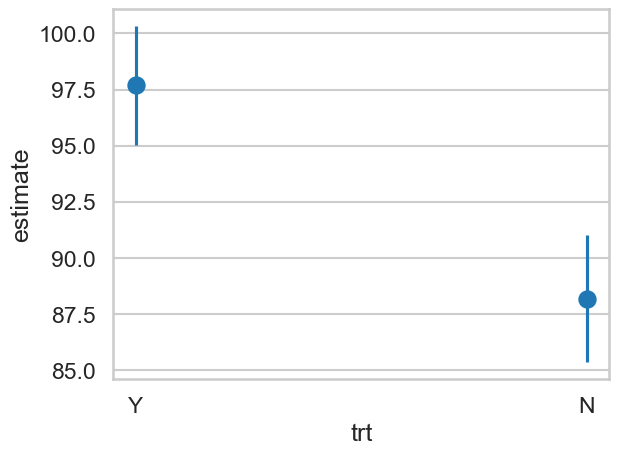

In [5]:
# Plot
ax = sns.pointplot(data=p,
                   x='trt', y='estimate',
                   linestyle='none')
# Add errors
ax.vlines(p['trt'], p['conf_low'], p['conf_high'])

## Testing hypotheses

We can compute the difference between these two as usual with the `hypothesis` argument, and obtain the interval around the difference:

In [6]:
# Difference
p = me.predictions(cog_mod,
                   newdata=me.datagrid(cog_mod,
                                       trt=['Y', 'N'],
                                       age=2),
                   hypothesis='b1=b2')
p

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1=b2""",9.490294,1.49698,6.339628,2.3032e-10,32.015641,6.556268,12.42432


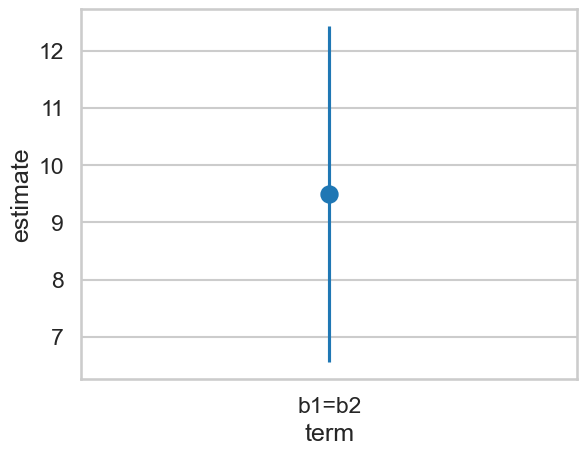

In [7]:
# Plot
ax = sns.pointplot(data=p,
                   x='term', y='estimate',
                   linestyle='none')
# Add errors
ax.vlines(p['term'], p['conf_low'], p['conf_high'])

The *p*-value of this difference is significant, as it shows that we'd not expect to see a difference as large as this if the difference between the interventions was zero.

But that's often a bit of a silly hypothesis to begin with. We'd not run the intervention (or study, or wherever we get our data!) if we thought the difference was really *nothing* to start with. 

Instead, imagine the scenario that your new intervention is out to beat an existing one. That one showed a difference of 7 units by age 2. Is this intervention better than that? Testing this is simple:

In [8]:
# Difference
p = me.predictions(cog_mod,
                   newdata=me.datagrid(cog_mod,
                                       trt=['Y', 'N'],
                                       age=2),
                   hypothesis='b1-b2 = 7') 
# Subtract one from the other, is it equal to 7?
p

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1-b2=6""",3.490294,1.49698,2.331557,0.019724,5.663905,0.556268,6.42432


The predicted difference from seven - *not* zero - is about 2.5, and it is not significant. But note the confidence interval - it might be just less than 7, or quite a bit above it. So while it is not statistically significant, this might well be worth pursuing! This is an example of a large prediction with a wide interval. If the null value is zero this is comfortably significant, but if its 7, it is not - but the interval indicates the effect could be rather a bit larger than 7. Circumstance dictates what the appropriate outcome is.

You can test almost any hypothesis with `marginaleffects` with a careful application, and often, the hypothesis of zero is not that interesting!

## Testing an interval hypothesis
We can also express a hypothesis as an interval. 

Imagine this somewhat complex scenario:
- A previous, more expensive intervention produces a change of 7 points.
- We are tasked with seeing if our intervention is *at least as good as* - i.e., *is equivalent* to the existing one, for children aged 2.
- The current intervention will replace the existing one, if it can be shown to be equivalent to give an increase of at least 6.5 - 12.5.
- The developers would like it to be better than 7, but they'll accept anywhere between 6.5 and 12.5 as equivalent.

Testing this kind of 'interval' hypothesis is easy, but a bit confusing philosophically. A significant result means our estimate is *within* the bounds specified, a non-significant one indicating one or both of the bounds are within the confidence interval and cannot be excluded - i.e., the effect could be lower than 6.5 or bigger than 12.5. We do this using the `equivalence` keyword and a list of the lower and upper bounds, in addition to the standard hypothesis:

In [9]:
# Equivalence
eq = me.predictions(cog_mod,
                    newdata=me.datagrid(cog_mod,
                                        trt=['Y', 'N'],
                                        age=2),
                    hypothesis='b1=b2',
                    equivalence=[6.5, 12.5])
eq

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,statistic_noninf,statistic_nonsup,p_value_noninf,p_value_nonsup,p_value_equiv
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""b1=b2""",9.490294,1.49698,6.339628,2.3032e-10,32.015641,6.556268,12.42432,1.997552,-2.010519,0.022883,0.022188,0.022883


The `p_value_equiv` contains the information we need. Illustrating this graphically:

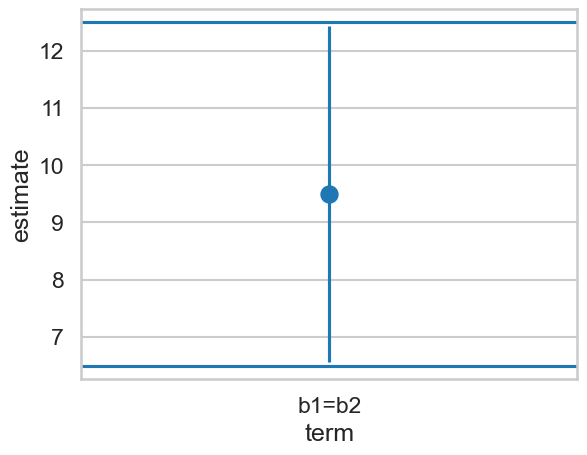

In [10]:
# Plot
ax = sns.pointplot(data=eq, x='term', y='estimate')
ax.vlines(eq['term'], eq['conf_low'], eq['conf_high'])
ax.axhline(6.5)
ax.axhline(12.5)

This technique can be very useful. Sometimes you may see a small, precise, and significant result. Rather than taking this as evidence, we may test whether the result is within an interval of effects we could consider either important or unimportant (the definition is up to you!), and test *that*. 

The downside is that defining these intervals is difficult, requires justification, and can be frowned on by less statistically literate folk.

## One more example
Lets consider another example, revisiting the beauty and wages dataset. First, we read it in and fit a simple model where we predict hourly wages from a `looks` variable that goes from 1 to 5, and an `exper` variable that counts the persons years of experience in the workforce. This shows a statistically significant effect of looks and experience:

In [11]:
# Read in looks
looks = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/wooldridge/beauty.csv')

# Fit a simple model and examine output
looks_mod = smf.ols('wage ~ exper + looks', data=looks).fit()
looks_mod.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
No. Observations:                1260   F-statistic:                     42.70
Covariance Type:            nonrobust   Prob (F-statistic):           1.15e-18
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5094      0.671      3.742      0.000       1.194       3.825
exper          0.0971      0.011      9.018      0.000       0.076       0.118
looks          0.6373      0.188      3.390      0.001       0.268       1.006
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As a silly example, lets assume taking up regular exercise, clean eating, and expensive beauty products will shift your looks from a 3 to a 4. Averaging over your years of experience, how much does going from a 3 to a 4 increase your hourly wage?

In [12]:
# Make a datagrid
dg = me.datagrid(looks_mod,
                 looks=[3, 4],
                 exper=np.arange(1, 40)
                )

# Make the predictions
p = me.predictions(looks_mod,
                   newdata=dg,
                   by='looks') # average over experience

p

looks,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
i64,f64,f64,f64,f64,f64,f64,f64
3,6.362436,0.132481,48.025307,0.0,inf,6.102778,6.622094
4,6.999705,0.202224,34.61356,0.0,inf,6.603352,7.396057


With looks of about 3, you earn 6.36 an hour. With a four, you earn basically 7. Is this difference statistically significant?

In [13]:
# Include hypothesis of zero difference, test to reject
me.predictions(looks_mod,
               newdata=dg,
               by='looks',
               hypothesis='b2 - b1 = 0') # Same as b2=b1 or 4 - 3

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2-b1=0""",0.637269,0.188008,3.389585,0.0007,10.480386,0.26878,1.005757


The difference of about 0.64 is significant. Hold on though, all that exercise, expensive products and good food is a LOT of effort. Will it earn you at least an extra 0.50 an hour?

In [14]:
# Include hypothesis of a 50-cent difference, test to reject
me.predictions(looks_mod,
               newdata=dg,
               by='looks',
               hypothesis='b2 - b1 = 0.50') 

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b2-b1=0.50""",0.137269,0.188008,0.730122,0.465316,1.103719,-0.23122,0.505757


This difference is not statistically significant, so you conclude the conclude there's no evidence it will improve your wages above 50 cents an hour.

Imagine now you say - this increase of a 3 to a 4 is going to be a lot of work.

Anything from an increase of 0.01 to 1 dollar is absolutely not worth it, and so I'll consider that increase equivalent to what I currently earn - all the gym memberships and beauty products will cost me more than that. An increase of 0.01 to 1 dollar is my interval hypothesis.

You can test that hypothesis like so:

In [15]:
# Equivalence hypothesis
eq = me.predictions(looks_mod,
                    newdata=dg,
                    by='looks',
                    hypothesis='b2 - b1 = 0',
                    equivalence=[0.01, 1.])
eq

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,statistic_noninf,statistic_nonsup,p_value_noninf,p_value_nonsup,p_value_equiv
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""b2-b1=0""",0.637269,0.188008,3.389585,0.0007,10.480386,0.26878,1.005757,3.336395,-1.929341,0.000424,0.026844,0.026844


This *is* significant, which indicates the effect *is within the interval*, and thus you can conclude the end result is the same as what you presently earn:

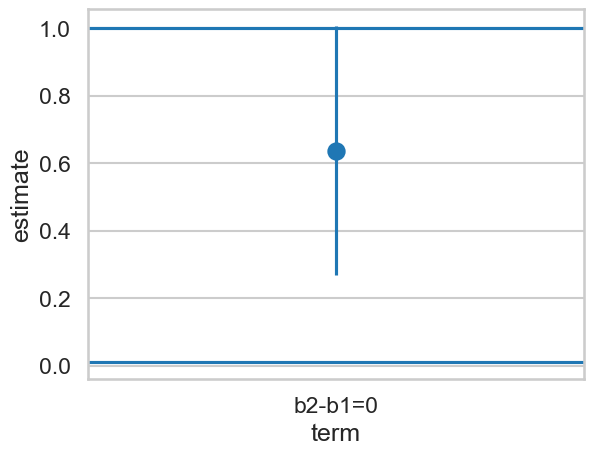

In [16]:
# Plot
ax = sns.pointplot(data=eq, x='term', y='estimate')
ax.vlines(eq['term'], eq['conf_low'], eq['conf_high'])
ax.axhline(0.01)
ax.axhline(1)

To reiterate, this test is significant, which means you can say the effect is *unintersting, null, or too small to be of interest*. If the test was *not* significant, you would conclude that the intervention on your looks could possibly yield effects outside of this interval and thus *could be of interest*.